In [1]:
import pandas as pd
from math import dist
import itertools as it
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [2]:
data = [[ 0,  0],
        [-3,  3],
        [ 1, 11],
        [ 4,  7],
        [-5,  9],
        [-5,  2],
        [-4, -7],
        [ 6,  0],
        [ 3, -6],
        [-1, -3],
        [ 0, -6],
        [ 6,  4],
        [ 2,  5],
        [-2,  8],
        [ 6, 10],
        [ 1,  8],
        [-3,  1],
        [-6,  5],
        [ 2,  9],
        [-6, -5],
        [ 5, -4]]

farms = list(range(21)) # 0 is depot
farms_comb = list(it.permutations(farms, 2))
days = [1, 2]
coord = pd.DataFrame([[p[0]*10,p[1]*10] for p in data], 
                     columns = ['x', 'y'], index = farms)
col_freq = dict(zip(farms, [0] + [1 for i in range(9)] + [2 for i in range(10, 21)]))
col_req  = dict(zip(farms, [0, 5, 4, 3, 6, 7, 3, 4, 6, 5, 4, 7, 3, 4, 5, 6, 8, 5, 7, 6, 6]))
tank_cap = 80

dest = {i: [j for j in farms if j!=i] for i in farms}

In [3]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # list of edges selected in the current solution
        vals = model.cbGetSolution(model._x)
        
        # list of edges selected in day 1
        sel1 = gp.tuplelist((i, j) for i,j,k in vals.keys() if (k==1 and vals[i,j,k]>0.9))
        # find a cycle in sel1:
        nodes1 = set()
        for i,j in sel1:
            nodes1.add(i)
            nodes1.add(j)
        tour1 = subtour(sel1)
        # now, if a tour smaller than our current solution was found (meaning, it's a subtour),
        # add a subtour elimination constraint to forbid it in the model for day 1 and 2
        if len(tour1) < len(nodes1):
            model.cbLazy(gp.quicksum(model._x[i,j,1] for i,j in it.permutations(tour1, 2))
                        <= len(tour1)-1)
            model.cbLazy(gp.quicksum(model._x[i,j,2] for i,j in it.permutations(tour1, 2))
                        <= len(tour1)-1)

        
        # list of edges selected in day 2
        sel2 = gp.tuplelist((i, j) for i,j,k in vals.keys() if (k==2 and vals[i,j,k]>0.9))
        # find a cycle in sel2:
        nodes2 = set()
        for i,j in sel2:
            nodes2.add(i)
            nodes2.add(j)
        tour2 = subtour(sel2)
        
        if len(tour2) < len(nodes2):
            model.cbLazy(gp.quicksum(model._x[i,j,2] for i,j in it.permutations(tour2, 2))
                        <= len(tour2)-1)
            model.cbLazy(gp.quicksum(model._x[i,j,2] for i,j in it.permutations(tour2, 2))
                        <= len(tour2)-1)
       
def subtour(edges):
    nodes = set()
    for i,j in edges:
        nodes.add(i)
        nodes.add(j)
        
    unvis = list(nodes)
    cycle = list(nodes)
    
    while unvis:
        thiscycle = []
        neighbors = unvis
        
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvis.remove(current)
            neighbors = [j for i, j in edges.select(current, '*') if j in unvis]
            
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle
    return cycle    

In [4]:
model = gp.Model('Milk Collection')

# add vars
x = model.addVars(farms_comb, days,
                  vtype=GRB.BINARY,
                  name='x')
y = model.addVars(farms, days,
                  vtype=GRB.BINARY,
                  name='y')
y[11,1].lb=1

# objective function
model.setObjective(gp.quicksum(dist((coord['x'][i], coord['y'][i]), 
                                    (coord['x'][j], coord['y'][j]))*x[i,j,k] for i,j,k in x))

# add constraints
model.addConstrs((gp.quicksum(col_req[i]*y[i,k] for i in farms) <= tank_cap for k in days),
                 name='tank_cap_day')

model.addConstrs((y[i,1] + y[i,2] == 1 for i in farms[10:]),
                 name='visit_once')

model.addConstrs((y[i,1] + y[i,2] == 2 for i in farms[:10]),
                 name='visit_twice')

model.addConstrs((gp.quicksum(x[i,j,1] for j in dest[i])
                 + gp.quicksum(x[j,i,1] for j in dest[i]) == 2 for i in farms[:10]),  # includes depot, is it ok?
                 name='visit_everyday1')

model.addConstrs((gp.quicksum(x[i,j,2] for j in dest[i])
                 + gp.quicksum(x[j,i,2] for j in dest[i]) == 2 for i in farms[:10]),  # includes depot, is it ok?
                 name='visit_everyday2')

model.addConstrs((gp.quicksum(x[i,j,1] for j in dest[i])
                 + gp.quicksum(x[j,i,1] for j in dest[i])
                 - 2*y[i,1] == 0 for i in farms[10:]),  # includes depot, is it ok?
                 name='visit_otherday1')

model.addConstrs((gp.quicksum(x[i,j,2] for j in dest[i])
                 + gp.quicksum(x[j,i,2] for j in dest[i])
                 - 2*y[i,2] == 0 for i in farms[10:]),  # includes depot, is it ok?
                 name='visit_otherday2')

model.addConstrs((x[i,j,k] - y[i,k] <= 0 for i in farms for j in dest[i] for k in days))

model.addConstr((gp.quicksum(x[0,j,1] for j in dest[0]) == 1),
                 name='leave_depot1')

model.addConstr((gp.quicksum(x[0,j,2] for j in dest[0]) == 1),
                 name='leave_depot2')

model.addConstr((gp.quicksum(x[i,0,1] for i in dest[0]) == 1),
                 name='arrive_depot1')

model.addConstr((gp.quicksum(x[i,0,2] for i in dest[0]) == 1),
                 name='arrive_depot2')

model.addConstrs((gp.quicksum(x[i,j,1] - x[j,k,1] for i in dest[j] for k in dest[j] if k!=i)
                 == 0 for j in farms),
                 name='flow_farm1')

model.addConstrs((gp.quicksum(x[i,j,2] - x[j,k,2] for i in dest[j] for k in dest[j] if k!=i)
                 == 0 for j in farms),
                 name='flow_farm2')

model.update()

Academic license - for non-commercial use only - expires 2021-05-07
Using license file C:\Users\naraq\gurobi.lic


In [5]:
model._x = x
model.Params.LazyConstraints = 1
model.write('Milk Collection.lp')
model.optimize(subtourelim)

Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 951 rows, 882 columns and 5224 nonzeros
Model fingerprint: 0x69e3bdd2
Variable types: 0 continuous, 882 integer (882 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 867 rows and 72 columns
Presolve time: 0.00s
Presolved: 84 rows, 810 columns, 2582 nonzeros
Variable types: 0 continuous, 810 integer (810 binary)

Root relaxation: objective 1.024806e+03, 89 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1049.38538    0   28          - 1049.38538      -     -    0s
     0     0

In [6]:
print('Day 1')
k = 1
for i, j, v in x:
    if v==k and x[i,j,k].x > 0:
        print('From {:2} to {:2}'.format(i,j))

print('\nDay 2')
k = 2
for i, j, v in x:
    if v==k and x[i,j,k].x > 0:
        print('From {:2} to {:2}'.format(i,j))

Day 1
From  0 to 16
From  1 to  4
From  2 to 14
From  3 to 11
From  4 to 13
From  5 to  1
From  6 to  9
From  7 to 20
From  8 to 10
From  9 to  0
From 10 to  6
From 11 to  7
From 13 to  2
From 14 to  2
From 14 to  3
From 16 to  5
From 20 to  8

Day 2
From  0 to  1
From  1 to  5
From  2 to 18
From  3 to 12
From  4 to  2
From  5 to 17
From  6 to 19
From  7 to  8
From  8 to  6
From  9 to  0
From 12 to  7
From 15 to  3
From 17 to  4
From 18 to 15
From 19 to  9


Total routes length 1212 miles


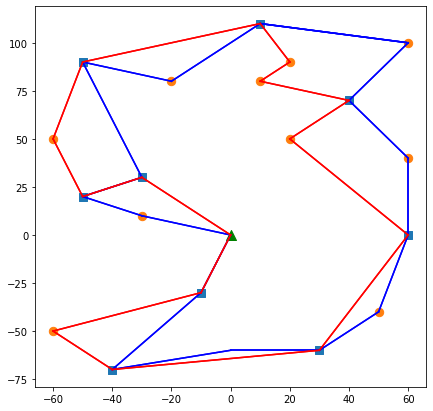

In [7]:
print('Total routes length {:.0f} miles'.format(model.ObjVal))
plt.figure(figsize=(7,7))

plt.scatter(coord.x[0], coord.y[0], marker='^', s=100, color='g')
plt.scatter(coord.x[1:10], coord.y[1:10], marker='s', s=70)
plt.scatter(coord.x[11:], coord.y[11:], marker='o', s=70)

k=1
for i, j, _ in x:
    if x[i,j,k].x > 0:
        plt.plot([coord.x[i], coord.x[j]], [coord.y[i], coord.y[j]], 'b-')
        
k=2
for i, j, _ in x:
    if x[i,j,k].x > 0:
        plt.plot([coord.x[i], coord.x[j]], [coord.y[i], coord.y[j]], 'r-')